In [ ]:
-- 1 запрос

SELECT COUNT(job_industry_category), job_industry_category 
FROM customer c
GROUP BY c.job_industry_category 
ORDER BY count(job_industry_category) DESC

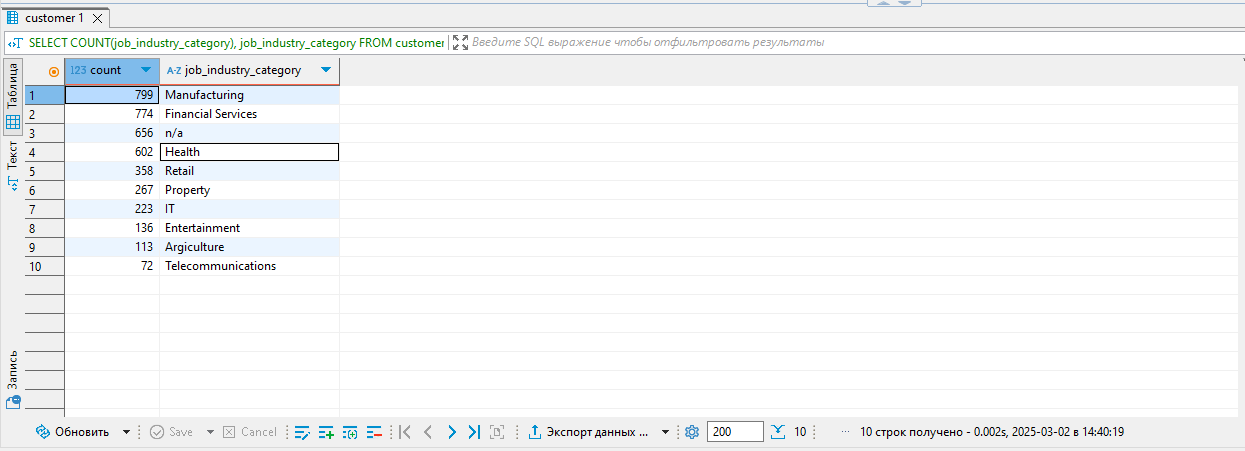

In [ ]:
-- 2 запрос

SELECT 
    EXTRACT(YEAR FROM t.transaction_date) AS year,
    EXTRACT(MONTH FROM t.transaction_date) AS month,
    c.job_industry_category,
    SUM(t.list_price) AS total_sales
FROM transaction t
JOIN customer c ON t.customer_id = c.customer_id
GROUP BY year, month, c.job_industry_category
ORDER BY year, month, c.job_industry_category;

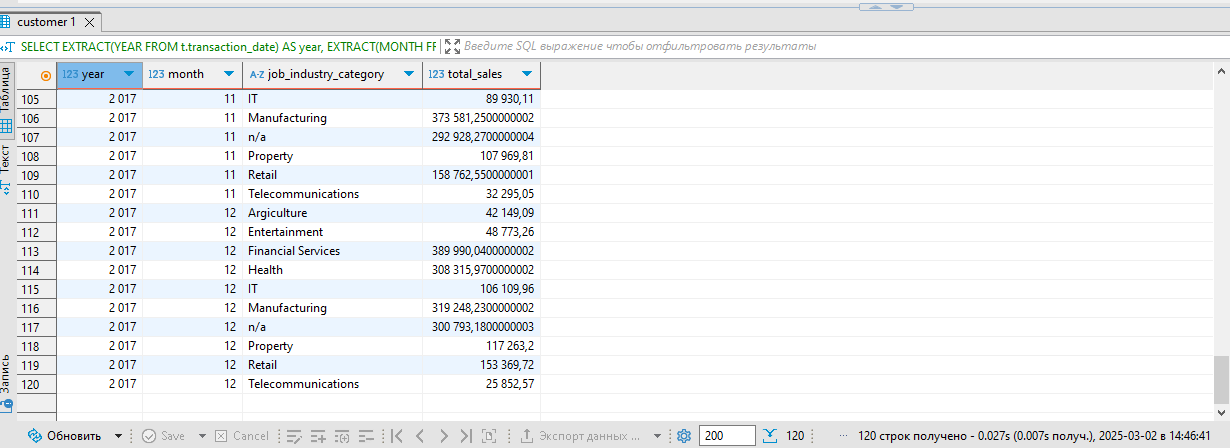

In [ ]:
-- 3 запрос

SELECT 
    t.brand, 
    COUNT(*) AS online_orders_count
FROM transaction t
JOIN customer c ON t.customer_id = c.customer_id
WHERE t.online_order = 'Yes'
    AND t.order_status = 'Approved'
    AND c.job_industry_category = 'IT'
GROUP BY t.brand
ORDER BY online_orders_count DESC;


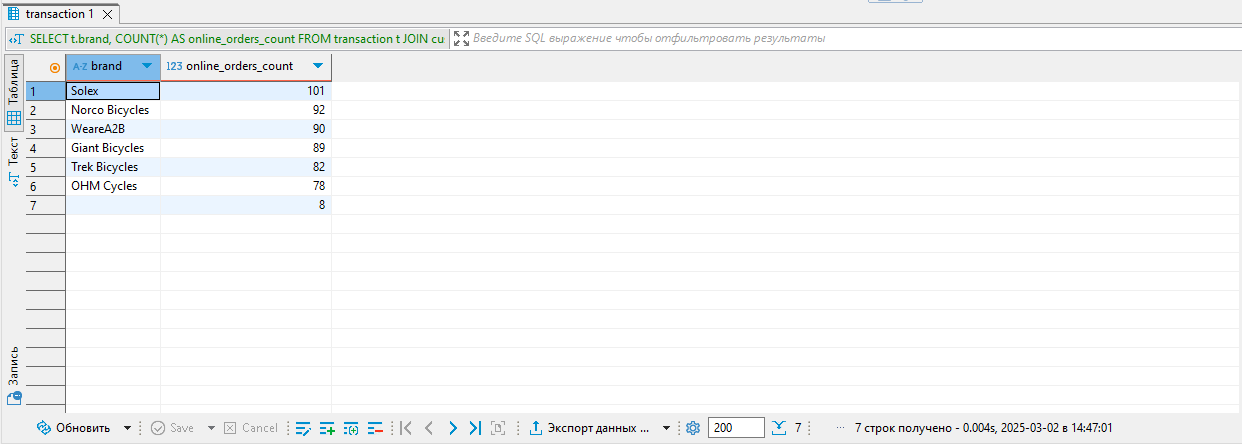

In [ ]:
-- 4 запрос

SELECT 
    t.customer_id,
    SUM(t.list_price) AS total_spent,
    MAX(t.list_price) AS max_transaction,
    MIN(t.list_price) AS min_transaction,
    COUNT(t.transaction_id) AS transaction_count
FROM transaction t
GROUP BY t.customer_id
ORDER BY total_spent DESC, transaction_count DESC;


SELECT DISTINCT
    t.customer_id,
    SUM(t.list_price) OVER (PARTITION BY t.customer_id) AS total_spent,
    MAX(t.list_price) OVER (PARTITION BY t.customer_id) AS max_transaction,
    MIN(t.list_price) OVER (PARTITION BY t.customer_id) AS min_transaction,
    COUNT(t.transaction_id) OVER (PARTITION BY t.customer_id) AS transaction_count
FROM transaction t
ORDER BY total_spent DESC, transaction_count DESC;

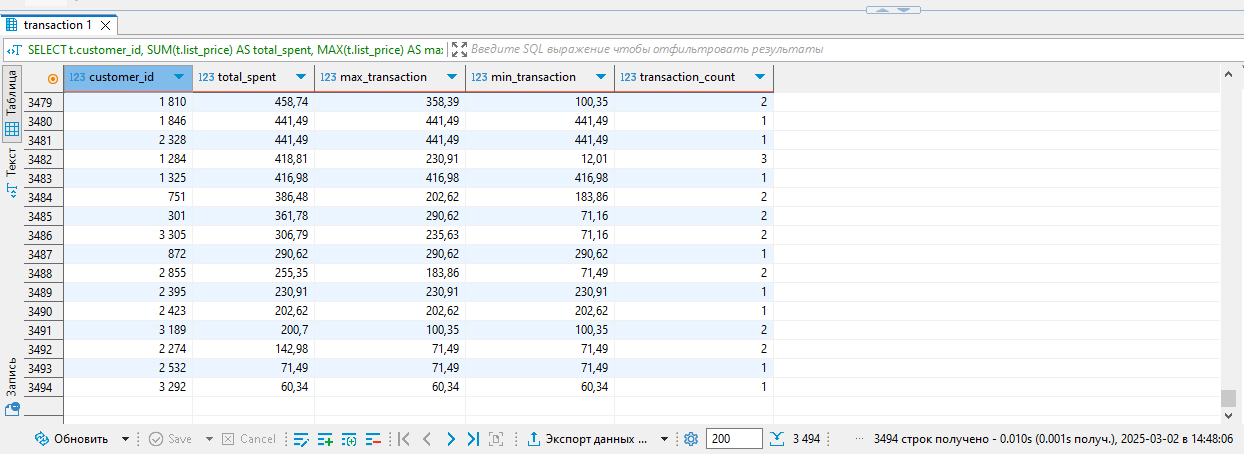

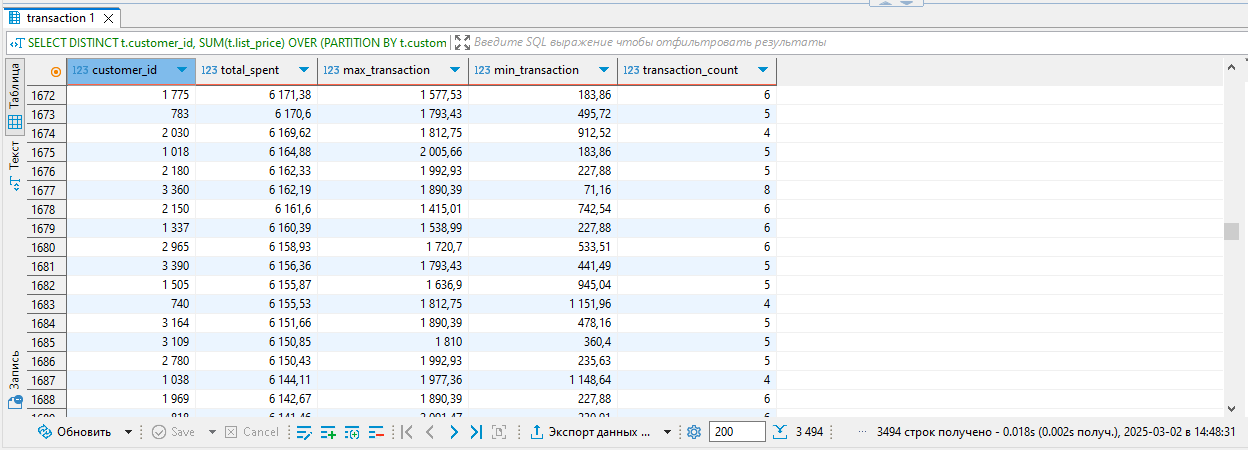

In [ ]:
-- 5 запрос

SELECT c.first_name, c.last_name, customer_total.total_spent
FROM (
    SELECT 
        t.customer_id, 
        SUM(t.list_price) AS total_spent
    FROM transaction t
    GROUP BY t.customer_id
) AS customer_total
JOIN customer c ON customer_total.customer_id = c.customer_id
WHERE customer_total.total_spent = (
    SELECT MAX(total_spent)
    FROM (
        SELECT customer_id, SUM(list_price) AS total_spent
        FROM transaction
        GROUP BY customer_id
    ) AS max_sum
);


WITH customer_total AS (
    SELECT 
        t.customer_id, 
        SUM(t.list_price) AS total_spent,
        RANK() OVER (ORDER BY SUM(t.list_price) DESC) AS rnk_max,
        RANK() OVER (ORDER BY SUM(t.list_price) ASC) AS rnk_min
    FROM transaction t
    GROUP BY t.customer_id
)
SELECT c.first_name, c.last_name, ct.total_spent
FROM customer_total ct
JOIN customer c ON ct.customer_id = c.customer_id
WHERE rnk_max = 1 OR rnk_min = 1;


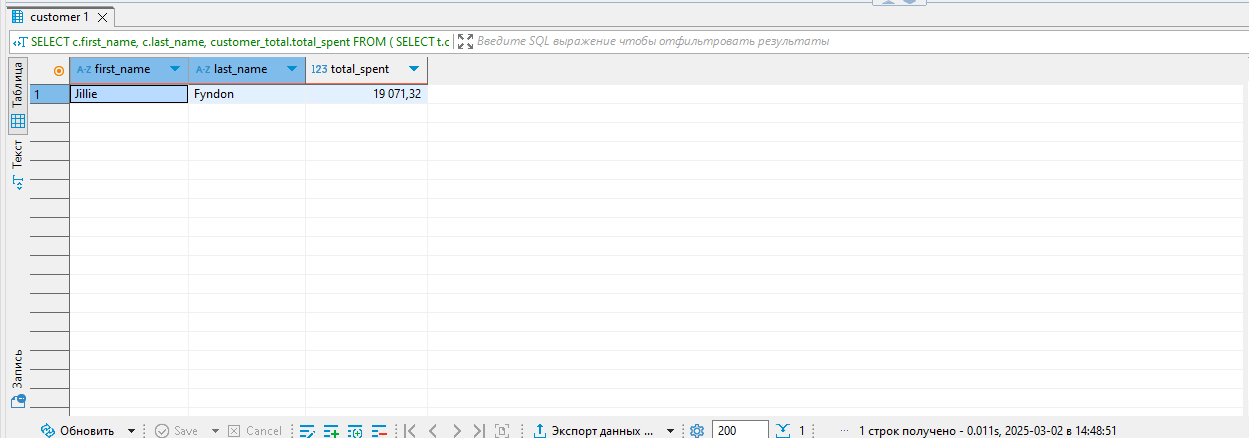

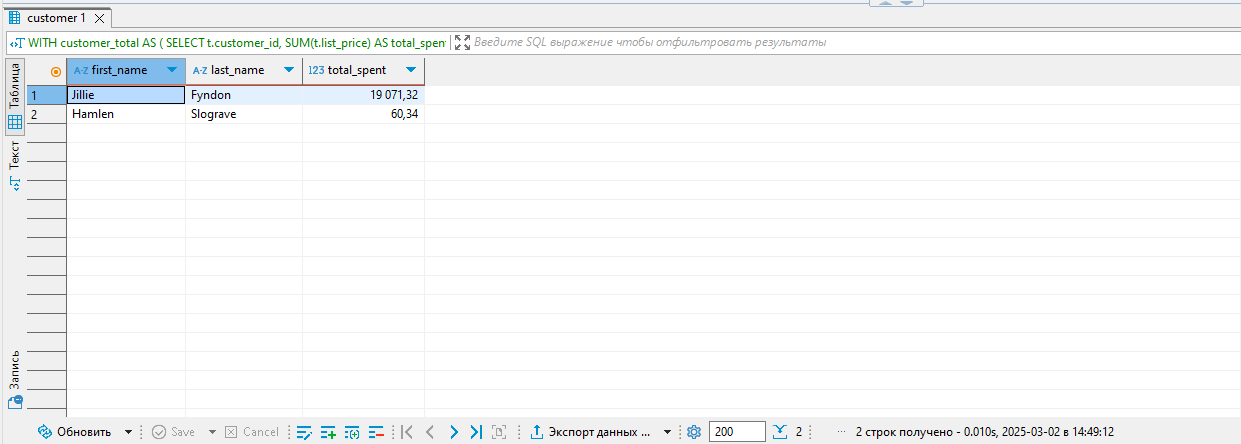

In [ ]:
-- 6 запрос 

SELECT customer_id, transaction_id, transaction_date, list_price
FROM (
    SELECT 
        customer_id, 
        transaction_id, 
        transaction_date, 
        list_price,
        RANK() OVER (PARTITION BY customer_id ORDER BY transaction_date ASC, transaction_id ASC) AS rnk
    FROM transaction
) AS ranked_transactions
WHERE rnk = 1;


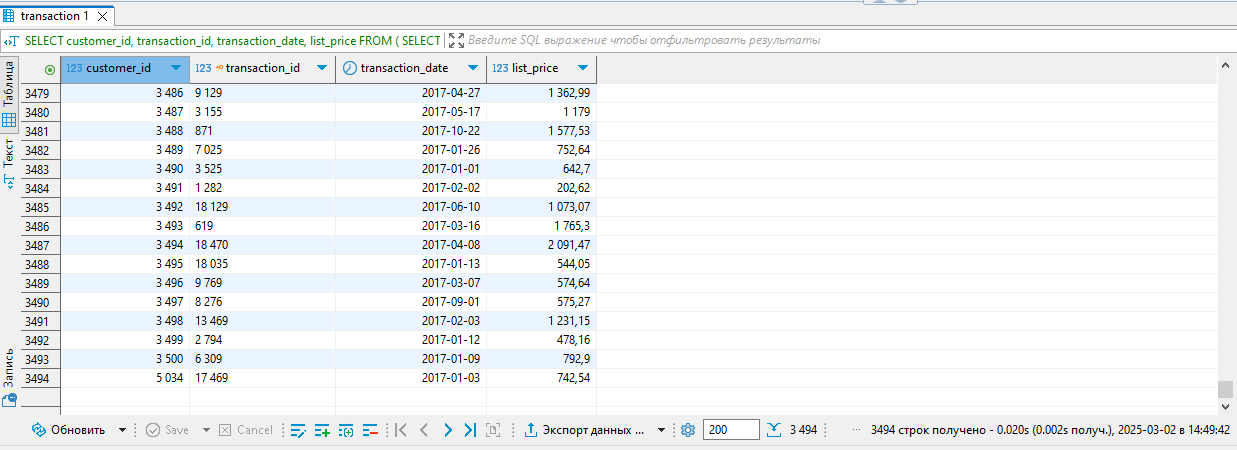

In [ ]:
-- 7 запрос

WITH transaction_intervals AS (
    SELECT 
        customer_id,
        transaction_date,
        LAG(transaction_date) OVER (PARTITION BY customer_id ORDER BY transaction_date) AS prev_date
    FROM transaction
),
intervals AS (
    SELECT 
        customer_id, 
        (transaction_date - prev_date) AS interval_days
    FROM transaction_intervals
    WHERE prev_date IS NOT NULL
)
SELECT c.first_name, c.last_name, c.job_title, i.interval_days
FROM intervals i
JOIN customer c ON i.customer_id = c.customer_id
WHERE i.interval_days = (SELECT MAX(interval_days) FROM intervals);

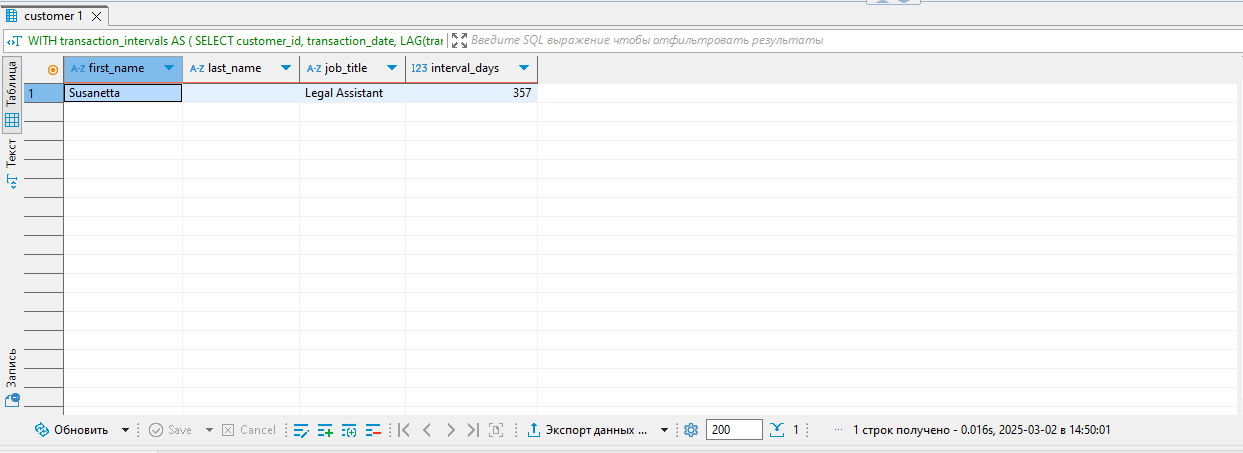